<center><h1>Automatic Roman Numeral Analysis</h1>
<h3>By Aaron Keller, Michael Cuevas, and David Zane </h3>
<h5>EECS 352</h5></center>

In [1]:
# This line is a convenience to import most packages you'll need. You may need to import others (e.g. random and cmath)
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, cmath,math, csv
from IPython.display import Audio
from sklearn.datasets import load_iris
from chord_training import training_chord_set, training_chord_labels,chord_dictionary,chord_vectors,ks_key_set,ks_key_labels,key_dictionary,key_index_dictionary,root_index_dictionary, major_roman_dictionary,minor_roman_dictionary
import librosa.display
%matplotlib inline

In [2]:
""" FUNCTION TO LOAD DESIGNATED AUDIO"""
def load_audio(audio_path):
    """
    Loads an audio file and returns the signal and sample rate. Also displays an audio player to play original sound
    
    Parameters
    ----------
    audio_path: string
        path to audio file to load
    
    Output
    ----------
    chord,sr: tuple
        contains the signal as index 0 and the sample rate as index 1
    """
    chord,sr = librosa.load(audio_path, sr=None)
    Audio(chord, rate=sr)
    return (chord, sr)


In [3]:
""" PLOTTING FUNCTIONS USED IN HPS ANALYSIS """

def plot_chromogram(signal, sr, n_fft, hop_length):
    """
    Displays a chromogram for a given signal
    
    Parameters
    ----------
    signal: 1D Numpy Array
        contains the original audio signal
    sr: int
        sample rate of the audio signal
    n_fft: int
        number of bins for the short time fourier transform
    hop_length: int
        size of each bin of the fourier transform
    """
    chromagram = librosa.feature.chroma_stft(chord, sr=sr, n_fft=2048, hop_length=1024)
    librosa.display.specshow(chromagram,y_axis='chroma',x_axis='time')
    plt.colorbar()
    plt.title('Chromagram')
    plt.tight_layout()
    plt.show()

def plot_fft(FFT, sr):
    """
    Displays a chromogram for a given signal
    
    Parameters
    ----------
    FFT: 1D Numpy Array
        contains the FFT of an audio signal
    sr: int
        sample rate of the audio signal
    """
    Nf = np.shape(FFT)[0]
    below_nyquist = FFT[0:int(Nf/2)+1]

    plt.figure()
    freq_arr = np.arange(int(Nf/2)+1) * (sr/Nf)
    plt.plot(freq_arr, below_nyquist)
    #plt.xlim([0,2000])
    #print(np.max(fft_chroma_test))
    
def plot_hps(hps, sr, type_sig):
    """
    Plots the harmonic product spectrum
    
    Parameters
    ----------
    hps: 1D Numpy Array
        contains the harmonic product spectrum of a signal
    type_sig: string
        contains the type of hps (either 'guitar' or 'piano')
    sr: int
        sample rate of the original audio signal
    """
    if(type_sig == 'guitar'):
        num_dec = 2**4
    else:
        num_dec = 2**2
    
    hps_max = np.amax(hps)
    hps = hps/hps_max
    
    plt.figure()
    win_len = len(hps)
    freq_arr = np.arange(win_len) * ((sr/num_dec)/win_len)
    plt.xlim([0,1000])
    plt.plot(freq_arr, hps)
    

In [4]:
""" FUNCTIONS USED FOR SIGNAL ANALYSIS """

def magnitude_spectrogram(signal, sr):
    """
    Displays a chromogram for a given signal
    
    Parameters
    ----------
    signal: 1D Numpy Array
        contains the original audio signal
    sr: int
        sample rate of the audio signal
    Output
    ----------
    FFT: 1D Numpy Array
        contains the magnitude spectrogram of the original signal
    """
    FFT = np.abs(np.fft.fft(signal))
    #fft_chroma_test = np.abs(fft_chroma_test)
    Nf = np.shape(FFT)[0]
    FFT = FFT[0:int(Nf/2)+1]
    return FFT

def hps_piano(mag_spec):
    """
    Calculates the harmonic product spectrum for a piano
    
    Parameters
    ----------
    mag_spec: 1D Numpy Array
        contains the magnitude spectrogram of the signal
    Output
    ----------
    hps: 1D Numpy Array
        contains the harmonic product spectrum
    """
    # decimates the audio 3 times
    dec1 = sp.signal.decimate(mag_spec, 1)
    dec2 = sp.signal.decimate(mag_spec, 2)
    dec3 = sp.signal.decimate(mag_spec, 4)
    
    # multiplies the decimated audio together to reduce overtones
    hps = np.zeros(len(dec3))
    for i in range(len(dec3)):
        product = dec1[i] * dec2[i] * dec3[i]
        hps[i] = product
    return hps

def hps_guitar(mag_spec):
    """
    Calculates the harmonic product spectrum for a guitar
    
    Parameters
    ----------
    mag_spec: 1D Numpy Array
        contains the magnitude spectrogram of the signal
    Output
    ----------
    hps: 1D Numpy Array
        contains the harmonic product spectrum
    """
    # decimates the audio signal 5 times to reduce overtones
    dec1 = sp.signal.decimate(mag_spec, 1)
    dec2 = sp.signal.decimate(mag_spec, 2)
    dec3 = sp.signal.decimate(mag_spec, 4)
    dec4 = sp.signal.decimate(mag_spec, 8)
    dec5 = sp.signal.decimate(mag_spec, 16)
    
    # multiplies the decimated audio together to reduce overtones
    hps = np.zeros(len(dec5))
    for i in range(len(dec5)):
        product = dec1[i] * dec2[i] * dec3[i] * dec4[i] * dec5[i]
        hps[i] = product
    return hps



In [5]:
def chromagram(hps,type_sig):
    """
    Generates a 12-bin chromagram from a harmonic product spectrum
    
    Parameters
    ----------
    hps: 1D Numpy Array
    bins: # of chromagram bins desired
       
    Output
    ----------
    chroma_vec: 1D Numpy Array with shape=(1,12)
    """
    
    # initialize output vector
    chroma_vec = np.zeros((12))
    
    if(type_sig == 'guitar'):
        num_dec = 2**4
    else:
        num_dec = 2**2
    
    #hps_max = np.amax(hps)
    #hps = hps/hps_max
    
    plt.figure()
    win_len = len(hps)
    freq_arr = np.arange(win_len) * ((sr/num_dec)/win_len)
    
    # do log2(freq) - floor(log2(freq)) for each element in hps
    # results in a # in range (0,1)
    for i in range(len(freq_arr)):
        if hps[i] <= 0:
            continue
        else:
            cbin = find_chroma_bin(freq_arr[i])
            chroma_vec[cbin] = chroma_vec[cbin] + hps[i]
      
    #scale chroma_vec between 0 and 1
    cmax = np.amax(chroma_vec)
    chroma_vec = chroma_vec / cmax
    
    # plot 12-bin chromagram
    plt.plot(np.linspace(0,11,12), chroma_vec, 'bo')
    plt.xlabel("Note Number")
    plt.show()
    
    return chroma_vec

def find_chroma_bin(freq):
    bin = 0
    i = np.log2(freq) - np.floor(np.log2(freq))
    if i < 1.0/12:
        bin = 0
    elif i>=1.0/12 and i<2.0/12:
        bin = 1
    elif i>=2.0/12 and i<3.0/12:
        bin = 2
    elif i>=3.0/12 and i<4.0/12:
        bin = 3
    elif i>=4.0/12 and i<5.0/12:
        bin = 4
    elif i>=5.0/12 and i<6.0/12:
        bin = 5
    elif i>=6.0/12 and i<7.0/12:
        bin = 6
    elif i>=7.0/12 and i<8.0/12:
        bin = 7
    elif i>=8.0/12 and i<9.0/12:
        bin = 8
    elif i>=9.0/12 and i<10.0/12:
        bin = 9
    elif i>=10.0/12 and i<11.0/12:
        bin = 10
    elif i>=11.0/12:
        bin = 11
    return bin


In [6]:
''' ########## KNN CHORD CLASSIFIER ########## '''
def knn(data_X, data_Y, query_X, dist_measure, k):
    query_rows = query_X.shape[0]
    data_rows = data_X.shape[0]
    cols = query_X.shape[1]
    res = np.zeros(query_rows)
    
    #iterate through each test example
    for i in range(query_rows):
        dist_arr = [None] * data_rows
        #iterate through the data examples and add the distance between each point and the test points to the distance array
        #as an array of tuples (index,distance)
        for j in range(data_rows):
            if dist_measure == 'euclidean':
                dist_arr[j] = (j,sp.spatial.distance.euclidean(query_X[i,:],data_X[j,:],2))
            elif dist_measure == 'cosine':
                dist_arr[j] = (j,sp.spatial.distance.cosine(query_X[i,:],data_X[j,:]))
                
        #Sort the array in ascending order by distance
        sorted_arr = sorted(dist_arr, key=lambda x:x[1])
        #Only need the first 'k' elements of the array
        k_neighbors = sorted_arr[0:k]
        classes = np.zeros(k)
        #create an array of class types corresponding to the classes of the elements in k_neighbors
        for l in range(k):
            index = k_neighbors[l][0]
            dclass = data_Y[index]
            classes[l] = dclass
        #Find the most common class type in classes[] by taking the mode
        closest = int(sp.stats.mode(classes)[0][0])
        res[i] = int(closest)
    return res


In [7]:
'''Krumhansl-Schmuckler Key Finding Algorithm'''
def create_key_time_vector(chord_progression):
    chords_vec = np.zeros(shape=(len(chord_progression),12))
    for i in range(len(chord_progression)):
        chords_vec[i,:] = chord_vectors[chord_progression[i]]
    key_time_vector = np.sum(chords_vec,axis=0)
    return key_time_vector

def ks(kt_vector):
    r_vector = np.zeros(24)
    for i in range(ks_key_set.shape[0]):
        r,p = sp.stats.pearsonr(ks_key_set[i,:],kt_vector)
        r_vector[i] = r
    key_index = np.argmax(r_vector)
    return key_dictionary[str(key_index)]
        

In [9]:
'''Roman Numeral Calculator'''
def calcRootDists(key, chord_progression):
    '''
    Inputs:
    key = String containing key
    chord_progression = Array of strings representing chord names
    
    Outputs:
    distVec = Array of computed distances between the roots of chords and the key center
    '''
    key_index = key_index_dictionary[key]
    distVec = np.zeros(len(chord_progression),dtype='int')
    for i in range(len(chord_progression)):
        root_index = root_index_dictionary[chord_progression[i][:2]]
        distVec[i] = np.mod(root_index-key_index,12, casting='same_kind')#(root_index - key_index) % 12
    return distVec
    
def generateRomanNumerals(distVec, key, chord_progression):
    dist_string_vec = np.array([None] * len(distVec))
    dist_quality_vec = np.array([None] * len(distVec))
    roman_numeral_vec = np.array([None] * len(distVec))
    for i in range(len(distVec)):
        if distVec[i] < 10:
            dist_string_vec[i] = '0' + str(distVec[i])
        else:
            dist_string_vec[i] = str(distVec[i])
        dist_quality_vec[i] = dist_string_vec[i] + str(chord_progression[i][2] + str(chord_progression[i][3]))
    
    for j in range(len(dist_quality_vec)):
        if 'Major' in key:
            roman_numeral_vec[j] = major_roman_dictionary[dist_quality_vec[j]]
        elif 'minor' in key:
            roman_numeral_vec[j] = minor_roman_dictionary[dist_quality_vec[j]]
    return roman_numeral_vec

In [37]:
base = './UMAPiano-DB-Poly-4/chords/UMAPiano-DB-'
base3 =  './UMAPiano-DB-Poly-3/chords/UMAPiano-DB-'
end = '-NO-F.wav'
chord1 = 'A3C5E5'
chord2 = 'E5G6Bb6C7'
chord3 = 'A3C5E5'
path = base3 + chord1 + end
path2 = base + chord2 + end
path3 = base3 + chord3 + end

[  8192  32768 123904 227840 338944 439296]
[[0.00195908]]
[[1.2935223e-05]]


C:\Users\akell\AppData\Local\Continuum\anaconda3\envs\eecs352\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log2
C:\Users\akell\AppData\Local\Continuum\anaconda3\envs\eecs352\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


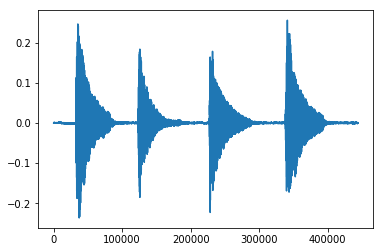

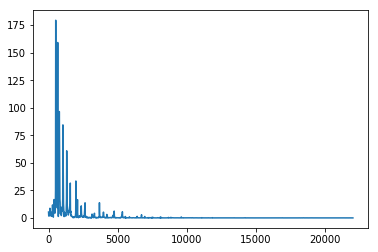

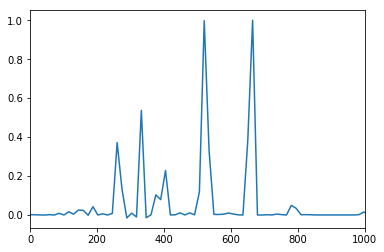

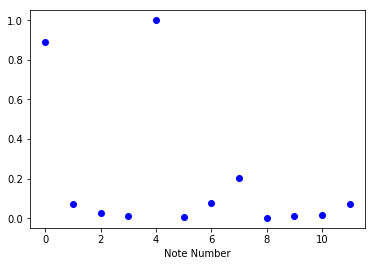

[[3.0201905e-05]]


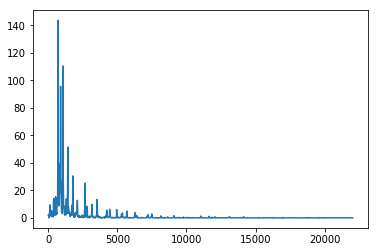

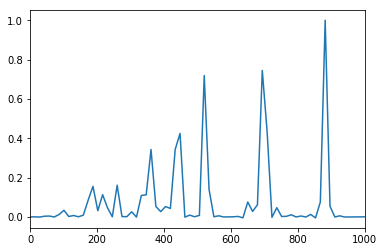

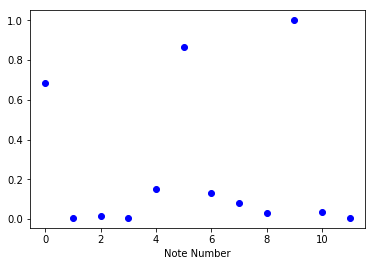

[[1.589234e-05]]


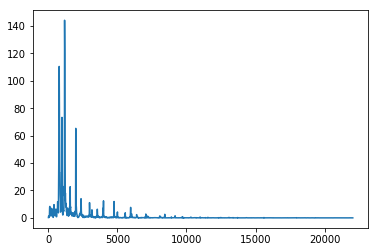

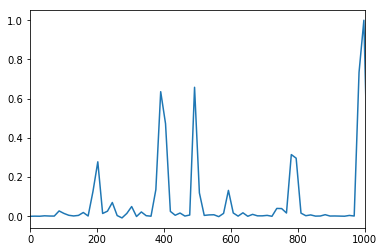

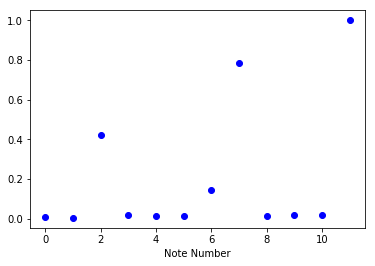

[[2.3310196e-05]]


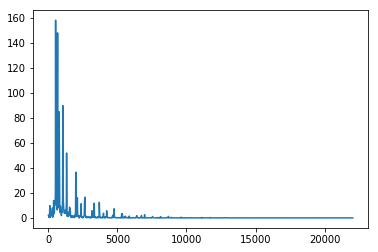

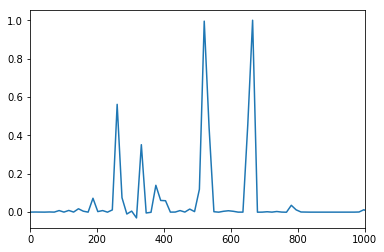

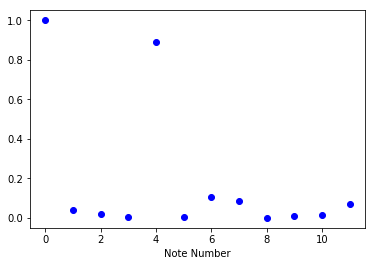

[[0.00367087]]
[3. 0. 1. 0. 2. 1. 0. 3. 0. 1. 0. 1.]
Key:  C Major , Progression:  ['C_M_' 'F_M_' 'G_M_' 'C_M_']


array(['I', 'IV', 'V', 'I'], dtype=object)

In [13]:
path4 = './Audio/I-IV-V-I.wav'
'''
chord1, sr = load_audio(path)
chord2, sr = load_audio(path2)
chord3, sr = load_audio(path3)
'''
sig_type = 'piano'
chord, sr = load_audio(path4)
'''
chord = np.append(chord1, chord2)
chord = np.append(chord, chord3)
'''
display(Audio(chord, rate=sr))
plt.figure(100)
plt.plot(chord)

times = librosa.onset.onset_detect(y=chord, sr=sr, units='samples')
print(times)
energies = np.zeros(len(times))
for i in range(len(times)):
    energies[i] = np.abs(chord[times[i]])

#print(energies)
#times = times[energies>=(.1*np.mean(energies))]
#print(times)
chord_progression = np.zeros(shape=(len(times),12))
counter = 0

# for each onset (chord) detected
white_noise = []
for i in times:
    # calculate magnitude spectrogram with values up to nyquist frequency and plot
    window_size = 6100
    spec = magnitude_spectrogram(chord[i:i+window_size], sr)
    sf = librosa.feature.spectral_flatness(y=chord[i:i+window_size], n_fft=window_size+1, hop_length=window_size+1)
    print(sf)
    if(sf <= 10**-3):
        white_noise.append(counter)
    
        plot_fft(spec, sr)

        # use HPS algorithm to reduce overtones
        if(sig_type == 'guitar'):
            hps = hps_guitar(spec)
        else:
            hps = hps_piano(spec)

        # plot HPS output
        plot_hps(hps, sr, sig_type)
        v = chromagram(hps,sig_type)
        chord_progression[counter,:] = v
        # output information about chord analysis

        Nf = np.shape(hps)[0]
        indices = np.argsort(hps)
        if(sig_type == 'guitar'):
            indices = indices*((sr/16)/Nf)
        else:
            indices = indices*((sr/4)/Nf)
        length = np.shape(indices)[0]
        counter = counter + 1
    
    # for testing purposes
    '''
    indexName = ''
    print("\nCHORD AT SAMPLE NUMBER: " + str(i+1) + "\n")
    for j in range(10):
        if(j == 0):
            indexName = "1st "
        if(j == 1):
            indexName = "2nd "
        if(j == 2):
            indexName = "3rd "
        else:
            indexName = str(j+1) + "th "
        print(indexName + "largest value: " + str(indices[length-1-j]) + "\n")
    '''

chord_progression = chord_progression[white_noise,:]
labels = knn(training_chord_set, training_chord_labels,chord_progression, 'cosine',1)
chord_names = [None] * len(labels)
for i in range(len(labels)):
    chord_names[i] = chord_dictionary[str(int(labels[i]))]
chord_names = np.array(chord_names)
#print(chord_names)
key_time = create_key_time_vector(chord_names)
print(key_time)
key = ks(key_time)
print('Key: ',key,', Progression: ', chord_names)

dists = calcRootDists(key,chord_names)
generateRomanNumerals(dists,key,chord_names)